
# Enriquecimiento Semántico y Visualización (Precision Agriculture)

Este notebook tiene como objetivo enriquecer el grafo de conocimiento de Agricultura de Precisión utilizando datos externos de **DBpedia** y generar visualizaciones analíticas.

**Fases:**
0.  Carga y Preparación
A.  Entity Linking (DBpedia Spotlight)
B.  Enriquecimiento de Datos (SPARQL Remoto)
C.  Consultas Complejas (SPARQL Local)
D.  Visualización
E.  Empaquetado


In [1]:

import pandas as pd
import rdflib
from rdflib import Graph, Literal, URIRef, Namespace
from rdflib.namespace import RDF, RDFS, OWL, FOAF, DCTERMS
import requests
import time
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import zipfile
import os
from tqdm import tqdm

# Configuración de Rutas Robustas
import os

# Detectar si estamos en la raíz del proyecto o en la carpeta notebooks
if os.path.exists("notebooks"):
    # Estamos en la raíz
    BASE_DIR = "notebooks"
elif os.path.exists("data") and os.path.exists("out"):
    # Estamos en la carpeta notebooks
    BASE_DIR = "."
else:
    # Fallback o estructura desconocida, asumimos local
    BASE_DIR = "."

DATA_DIR = os.path.join(BASE_DIR, "data", "processed")
OUT_DIR = os.path.join(BASE_DIR, "out")

INPUT_TTL = os.path.join(OUT_DIR, "agri_graph_improved.ttl")
OUTPUT_TTL = os.path.join(OUT_DIR, "enriched_graph.ttl")
PAPERS_CSV = os.path.join(DATA_DIR, "papers.csv")
FIELDS_CSV = os.path.join(DATA_DIR, "fields.csv")

# Namespaces
EX = Namespace("http://example.org/agri#")
DBO = Namespace("http://dbpedia.org/ontology/")
DBR = Namespace("http://dbpedia.org/resource/")

# Cargar Grafo
print(f"Cargando grafo desde: {os.path.abspath(INPUT_TTL)}")
if not os.path.exists(INPUT_TTL):
    raise FileNotFoundError(f"No se encuentra el archivo: {INPUT_TTL}")

g = Graph()
g.parse(INPUT_TTL, format="turtle")
print(f"Grafo cargado: {len(g)} triples")

# Cargar DataFrames
print(f"Cargando CSVs desde: {os.path.abspath(DATA_DIR)}")
if not os.path.exists(PAPERS_CSV):
    raise FileNotFoundError(f"No se encuentra el archivo: {PAPERS_CSV}")
    
papers_df = pd.read_csv(PAPERS_CSV)
fields_df = pd.read_csv(FIELDS_CSV)

# Limpieza básica
papers_df = papers_df.dropna(subset=['abstract', 'paperId'])
papers_df = papers_df[papers_df['abstract'].str.strip() != ""]
print(f"Papers válidos para análisis: {len(papers_df)}")


Cargando grafo desde: c:\Users\Usuario\Documents\Universidad\7mo Ciclo\InterOperabilidadYExplotDatos\Bim1InteroperabilidadDatos2B (2) - copia\Bim1InteroperabilidadDatos-main - copia (2) - copia\notebooks\out\agri_graph_improved.ttl
Grafo cargado: 71815 triples
Cargando CSVs desde: c:\Users\Usuario\Documents\Universidad\7mo Ciclo\InterOperabilidadYExplotDatos\Bim1InteroperabilidadDatos2B (2) - copia\Bim1InteroperabilidadDatos-main - copia (2) - copia\notebooks\data\processed
Papers válidos para análisis: 729


In [2]:

print("--- Fase A: Entity Linking (DBpedia Spotlight) ---")

SPOTLIGHT_API = "https://api.dbpedia-spotlight.org/en/annotate"
CONFIDENCE = 0.5
SUBSET_LIMIT = 50  # Límite para demo

count = 0
# Usamos tqdm para barra de progreso
for index, row in tqdm(papers_df.head(SUBSET_LIMIT).iterrows(), total=SUBSET_LIMIT, desc="Annotating Papers"):
    abstract = row['abstract']
    paper_id = row['paperId']
    paper_uri = URIRef(f"{EX}art-{str(paper_id)}")
    
    try:
        # Usamos POST para evitar error 414 URI Too Long con abstracts largos
        headers = {'Accept': 'application/json'}
        data = {'text': abstract, 'confidence': CONFIDENCE}
        
        response = requests.post(SPOTLIGHT_API, data=data, headers=headers, timeout=15)
        
        if response.status_code == 200:
            res_json = response.json()
            if 'Resources' in res_json:
                for res in res_json['Resources']:
                    dbpedia_uri = URIRef(res['@URI'])
                    # Triple: <Paper> schema:mentions <DBpediaEntity>
                    g.add((paper_uri, URIRef("http://schema.org/mentions"), dbpedia_uri))
        else:
            # Fallback a GET si POST falla (raro, pero por compatibilidad) o log de error sencillo
            # print(f"Warning: API status {response.status_code} for paper {paper_id}")
            pass
            
        time.sleep(0.5) # Respetar rate limits
        
    except Exception as e:
        print(f"Error procesando paper {paper_id}: {e}")

# Enlazar Keywords (Concepts)
print("Linking Keywords...")
for index, row in tqdm(fields_df.iterrows(), total=len(fields_df), desc="Linking Fields"):
    field_name = row['fieldName']
    
    try:
        # Para keywords cortas, GET está bien
        params = {'text': field_name, 'confidence': CONFIDENCE}
        headers = {'Accept': 'application/json'}
        response = requests.get(SPOTLIGHT_API, params=params, headers=headers, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            if 'Resources' in data:
                dbpedia_uri = URIRef(data['Resources'][0]['@URI'])
                
                # Buscar el concepto local por label
                # Asumimos que existen nodos concepto con skos:prefLabel == field_name
                # O creamos un nodo al vuelo si no existe mapeo directo conocido
                # Para este ejercicio, buscaremos en el grafo:
                
                query = f"""
                SELECT ?c WHERE {{
                    ?c a <http://www.w3.org/2004/02/skos/core#Concept> .
                    ?c <http://www.w3.org/2004/02/skos/core#prefLabel> "{field_name}" .
                }}
                """
                res = g.query(query)
                for r in res:
                    g.add((r.c, OWL.sameAs, dbpedia_uri))
        
        time.sleep(0.2)
    except Exception as e:
        print(f"Error linking field {field_name}: {e}")

print(f"Grafo post-linking: {len(g)} triples")


--- Fase A: Entity Linking (DBpedia Spotlight) ---


Annotating Papers: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Linking Keywords...


Linking Fields: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]

Grafo post-linking: 72448 triples


In [3]:

print("--- Fase B: Enriquecimiento (SPARQL Remoto) ---")

# 1. Identificar entidades a enriquecer
dbpedia_uris = set()
# De mentions
for o in g.objects(None, URIRef("http://schema.org/mentions")):
    if "dbpedia.org/resource" in str(o):
        dbpedia_uris.add(o)
# De sameAs
for o in g.objects(None, OWL.sameAs):
    if "dbpedia.org/resource" in str(o):
        dbpedia_uris.add(o)

print(f"Entidades únicas a enriquecer: {len(dbpedia_uris)}")

# 2. Configurar SPARQL Wrapper
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
uris_list = list(dbpedia_uris)
BATCH_SIZE = 50

# 3. Consultas Batch
for i in tqdm(range(0, len(uris_list), BATCH_SIZE), desc="Enriching Batches"):
    batch = uris_list[i:i+BATCH_SIZE]
    values_clause = " ".join([f"<{u}>" for u in batch])
    
    query = f"""
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX dbo: <http://dbpedia.org/ontology/>
    
    SELECT ?res ?name ?subject ?abstract WHERE {{
        VALUES ?res {{ {values_clause} }}
        OPTIONAL {{ ?res foaf:name ?name . }}
        OPTIONAL {{ ?res dct:subject ?subject . }}
        OPTIONAL {{ ?res dbo:abstract ?abstract . FILTER(LANG(?abstract) = "en") }}
    }}
    """
    
    try:
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        
        for result in results["results"]["bindings"]:
            res_uri = URIRef(result["res"]["value"])
            if "name" in result:
                g.add((res_uri, FOAF.name, Literal(result["name"]["value"])))
            if "subject" in result:
                g.add((res_uri, DCTERMS.subject, URIRef(result["subject"]["value"])))
            if "abstract" in result:
                g.add((res_uri, DBO.abstract, Literal(result["abstract"]["value"], lang='en')))
                
    except Exception as e:
        print(f"SPARQL Batch Error: {e}")
        time.sleep(1)

# Guardar grafo enriquecido
g.serialize(destination=OUTPUT_TTL, format="turtle")
print(f"Grafo enriquecido guardado en: {OUTPUT_TTL}")


--- Fase B: Enriquecimiento (SPARQL Remoto) ---
Entidades únicas a enriquecer: 479


Enriching Batches: 100%|██████████| 10/10 [01:14<00:00,  7.46s/it]


Grafo enriquecido guardado en: .\out\enriched_graph.ttl


In [4]:

print("--- Fase C: Consultas Complejas (SPARQL Local) ---")

# Consulta 1: Conceptos Dominantes
q1 = """
PREFIX schema: <http://schema.org/>
SELECT ?entity (COUNT(?paper) as ?mentionCount) WHERE {
    ?paper schema:mentions ?entity .
} GROUP BY ?entity ORDER BY DESC(?mentionCount) LIMIT 10
"""
print("\n1. Top 10 Entidades Mencionadas:")
for row in g.query(q1):
    # Usamos row['mentionCount'] o row.mentionCount de forma segura
    print(f"{row.mentionCount} - {row.entity.split('/')[-1]}")

# Consulta 2: Impacto por Tópico (Papers influyentes relacionados con tópicos enriquecidos)
# Modificado: Se usa OPTIONAL para el nombre de la entidad para garantizar resultados aunque no haya enriquecimiento completo
q2 = """
PREFIX schema: <http://schema.org/>
PREFIX ex: <http://example.org/agri#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?title ?cites ?entityName WHERE {
    ?paper a schema:Article ;
           schema:title ?title ;
           ex:citationCount ?cites ;
           schema:mentions ?entity .
    OPTIONAL { ?entity foaf:name ?n }
    BIND(COALESCE(?n, STR(?entity)) AS ?entityName)
    FILTER(?cites > 0)
} ORDER BY DESC(?cites) LIMIT 5
"""
print("\n2. Papers influyentes (Tópicos Enriquecidos):")
for row in g.query(q2):
    print(f"[{row.cites}] {row.title[:40]}... -> {row.entityName}")

# Consulta 3: Pares de Entidades Co-ocurrentes (Red de Conocimiento)
q3 = """
PREFIX schema: <http://schema.org/>
SELECT ?e1 ?e2 (COUNT(?paper) as ?coCount) WHERE {
    ?paper schema:mentions ?e1 .
    ?paper schema:mentions ?e2 .
    FILTER(STR(?e1) < STR(?e2))
} GROUP BY ?e1 ?e2 ORDER BY DESC(?coCount) LIMIT 15
"""
print("\n3. Top Pares de Entidades Co-ocurrentes:")
for row in g.query(q3):
    print(f"{row.coCount}: {row.e1.split('/')[-1]} <-> {row.e2.split('/')[-1]}")

# Consulta 4: Autores Polímatas (Diversidad de Tópicos)
# Modificado: Uso correcto de schema:name para autores
q4 = """
PREFIX schema: <http://schema.org/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
SELECT ?authorName (COUNT(DISTINCT ?entity) as ?topicCount) WHERE {
    ?paper schema:author ?author .
    ?author schema:name ?authorName .
    ?paper schema:mentions ?entity .
} GROUP BY ?authorName ORDER BY DESC(?topicCount) LIMIT 10
"""
print("\n4. Autores con mayor diversidad de tópicos:")
for row in g.query(q4):
    print(f"{row.topicCount} temas - {row.authorName}")

# Consulta 5: Validación de Keywords (SameAs)
q5 = """
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?label ?dbpediaURI WHERE {
    ?c a skos:Concept ;
       skos:prefLabel ?label ;
       owl:sameAs ?dbpediaURI .
} LIMIT 10
"""
print("\n5. Ejemplo de Validación de Links (Local -> DBpedia):")
for row in g.query(q5):
    print(f"{row.label} -> {row.dbpediaURI}")


--- Fase C: Consultas Complejas (SPARQL Local) ---

1. Top 10 Entidades Mencionadas:
25 - Precision_agriculture
17 - Agriculture
8 - Remote_sensing
6 - Wireless_sensor_network
6 - Wireless
6 - Unmanned_aerial_vehicle
5 - Algorithm
4 - Internet
4 - Hyperspectral_imaging
4 - Machine_learning

2. Papers influyentes (Tópicos Enriquecidos):
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Unmanned_aerial_vehicle
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Wireless
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Remote_sensing
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Precision_agriculture
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Smart_device

3. Top Pares de Entidades Co-ocurrentes:
6: Precision_agriculture <-> Remote_sensing
5: Agriculture <-> Precision_agriculture
5: Precision_agriculture <-> Unm

--- Fase D: Visualizaciones ---


C:\Users\Usuario\AppData\Local\Temp\ipykernel_19520\974039405.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_viz, x="Count", y="Entity", palette="viridis")


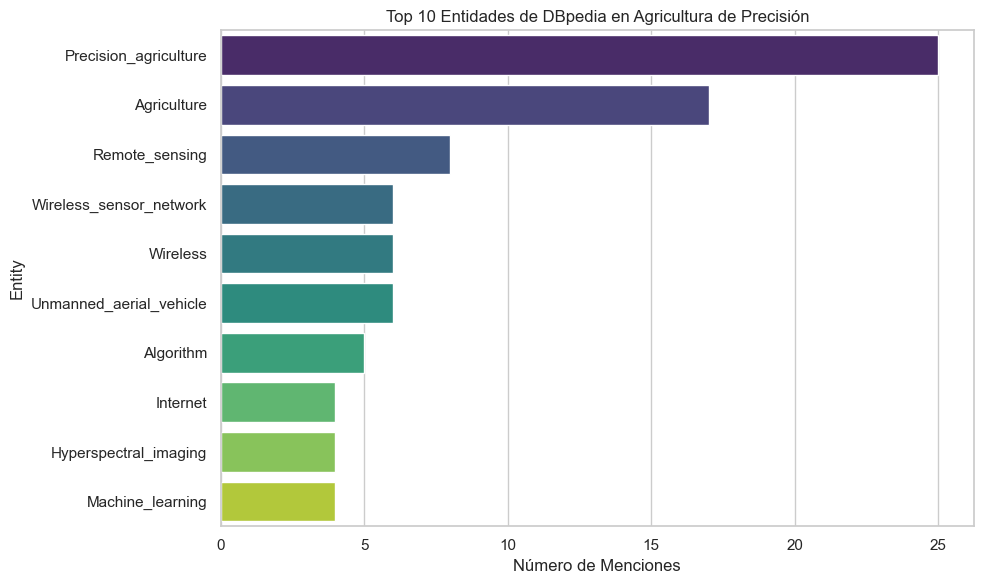

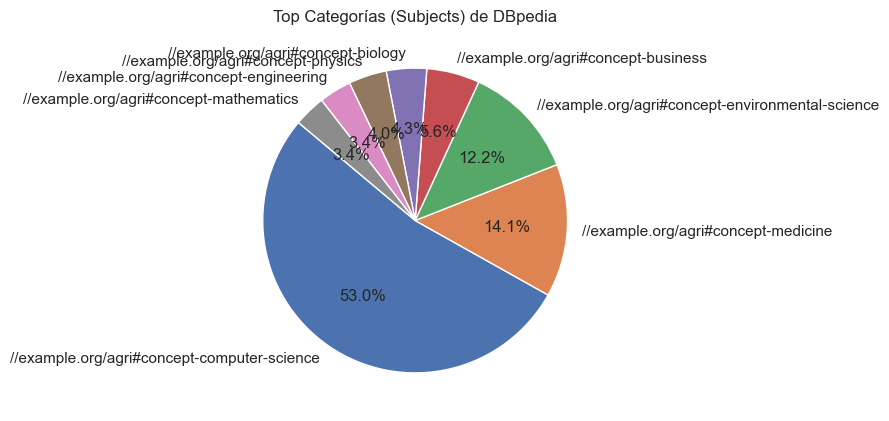

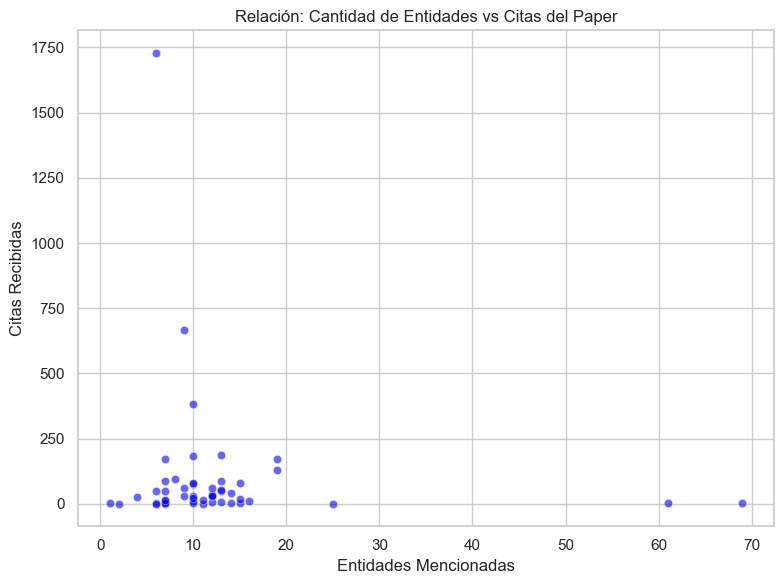

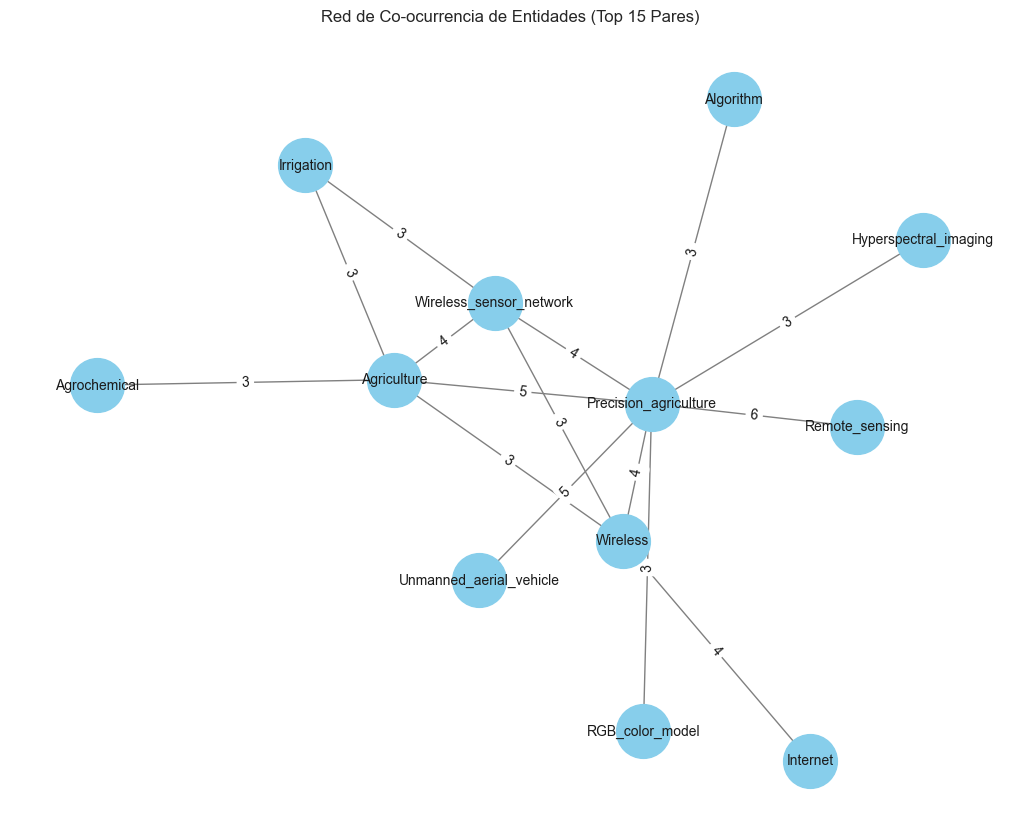

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19520\974039405.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_auth, x="Topics", y="Author", palette="magma")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19520\974039405.py:92: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19520\974039405.py:93: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.savefig(os.path.join(OUT_DIR, "viz_authors.png"))
c:\Users\Usuario\Documents\Universidad\7mo Ciclo\InterOperabilidadYExplotDatos\Bim1InteroperabilidadDatos2B (2) - copia\Bim1InteroperabilidadDatos-main - copia (2) - copia\.venv_check\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io,

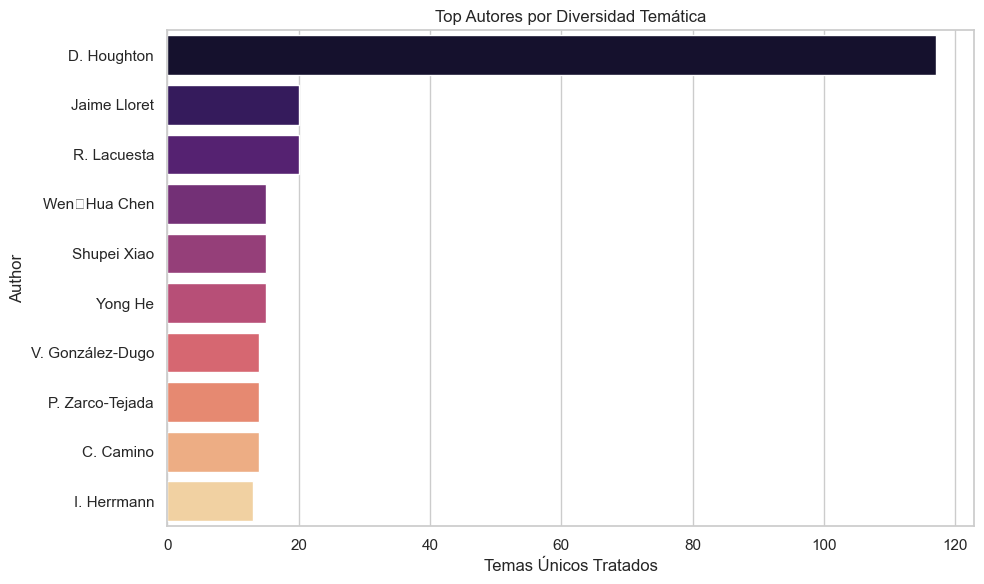

In [5]:

print("--- Fase D: Visualizaciones ---")
sns.set_theme(style="whitegrid")

# 1. Bar Chart: Top Entidades
res = g.query(q1)
data = []
for row in res:
    # Fix: avoid collision with row.count method
    data.append({"Entity": str(row.entity).split('/')[-1], "Count": int(row.mentionCount)})

df_viz = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_viz, x="Count", y="Entity", palette="viridis")
plt.title("Top 10 Entidades de DBpedia en Agricultura de Precisión")
plt.xlabel("Número de Menciones")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "viz_top_entities.png"))
plt.show()

# 2. Pie Chart: Subjects
q_sub = """
PREFIX dct: <http://purl.org/dc/terms/>
SELECT ?subject (COUNT(?s) as ?subjCount) WHERE {
    ?s dct:subject ?subject .
} GROUP BY ?subject ORDER BY DESC(?subjCount) LIMIT 8
"""
res_sub = g.query(q_sub)
labels = [str(r.subject).split(':')[-1] for r in res_sub]
sizes = [int(r.subjCount) for r in res_sub]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Top Categorías (Subjects) de DBpedia")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "viz_subjects_pie.png"))
plt.show()

# 3. Scatter Plot: Citas vs Menciones
# Obtenemos datos de papers individuales
q_scatter = """
PREFIX schema: <http://schema.org/>
PREFIX ex: <http://example.org/agri#>
SELECT ?paper (SAMPLE(?cites) as ?citationCount) (COUNT(?entity) as ?mentionCount) WHERE {
    ?paper a schema:Article ;
           ex:citationCount ?cites ;
           schema:mentions ?entity .
} GROUP BY ?paper LIMIT 100
"""
res_scatter = g.query(q_scatter)
data_scatter = [{"Cites": float(r.citationCount), "Mentions": int(r.mentionCount)} for r in res_scatter]
df_scatter = pd.DataFrame(data_scatter)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scatter, x="Mentions", y="Cites", color="blue", alpha=0.6)
plt.title("Relación: Cantidad de Entidades vs Citas del Paper")
plt.xlabel("Entidades Mencionadas")
plt.ylabel("Citas Recibidas")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "viz_scatter.png"))
plt.show()

# 4. Network Graph: Co-ocurrencia
# Usamos resultados de q3
res_q3 = g.query(q3)
G = nx.Graph()
for row in res_q3:
    e1 = str(row.e1).split('/')[-1]
    e2 = str(row.e2).split('/')[-1]
    w = int(row.coCount)
    G.add_edge(e1, e2, weight=w)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Red de Co-ocurrencia de Entidades (Top 15 Pares)")
plt.savefig(os.path.join(OUT_DIR, "viz_network.png"))
plt.show()

# 5. Horizontal Bar: Top Autores por Diversidad
# Usamos q4
res_q4 = g.query(q4)
data_auth = [{"Author": str(r.authorName), "Topics": int(r.topicCount)} for r in res_q4]
df_auth = pd.DataFrame(data_auth)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_auth, x="Topics", y="Author", palette="magma")
plt.title("Top Autores por Diversidad Temática")
plt.xlabel("Temas Únicos Tratados")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "viz_authors.png"))
plt.show()


In [6]:

print("--- Fase E: Empaquetado ---")

files_to_zip = [
    PAPERS_CSV,
    FIELDS_CSV,
    INPUT_TTL,
    OUTPUT_TTL,
    os.path.join(OUT_DIR, "viz_top_entities.png"),
    os.path.join(OUT_DIR, "viz_subjects_pie.png"),
    os.path.join(OUT_DIR, "viz_scatter.png"),
    os.path.join(OUT_DIR, "viz_network.png"),
    os.path.join(OUT_DIR, "viz_authors.png"),
    "Enrichment_and_Viz.ipynb" # Self-reference assumes file is saved
]

ZIP_NAME = "Entregable_Final.zip"
zip_path = os.path.join(OUT_DIR, ZIP_NAME)

with zipfile.ZipFile(zip_path, 'w') as zf:
    for f in files_to_zip:
        if os.path.exists(f):
            zf.write(f, os.path.basename(f))
        else:
            print(f"Warning: File {f} not found.")

print(f"✅ Archivo generado exitosamente: {zip_path}")


--- Fase E: Empaquetado ---
✅ Archivo generado exitosamente: .\out\Entregable_Final.zip
